In [70]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
import json
import librosa
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.layers import Dropout
import keras
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [50]:
Ravdess = "dataset/"

In [51]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
data_path.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
data_path.head()

,Emotions,Path
0,neutral,dataset/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,dataset/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,dataset/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,dataset/Actor_01/03-01-01-01-02-02-01.wav
4,calm,dataset/Actor_01/03-01-02-01-01-01-01.wav


In [52]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [53]:
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,dataset/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,dataset/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,dataset/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,dataset/Actor_01/03-01-01-01-02-02-01.wav
4,calm,dataset/Actor_01/03-01-02-01-01-01-01.wav


In [54]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [55]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [56]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [73]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

In [132]:
Features = pd.read_csv('features.csv')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [133]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [134]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [135]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [136]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [137]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

#model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 81, 256)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 81, 128)           163968    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 41, 128)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 41, 64)            41024     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 21, 64)          

In [138]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=0, min_lr=0.001)
history=model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
102/102 [==============================] - 4s 30ms/step - loss: 2.0449 - accuracy: 0.1819 - val_loss: 1.8578 - val_accuracy: 0.2815
Epoch 2/50
102/102 [==============================] - 3s 26ms/step - loss: 1.8884 - accuracy: 0.2410 - val_loss: 1.7190 - val_accuracy: 0.3731
Epoch 3/50
102/102 [==============================] - 3s 26ms/step - loss: 1.8082 - accuracy: 0.2898 - val_loss: 1.6524 - val_accuracy: 0.3843
Epoch 4/50
102/102 [==============================] - 3s 27ms/step - loss: 1.7399 - accuracy: 0.3329 - val_loss: 1.6052 - val_accuracy: 0.3778
Epoch 5/50
102/102 [==============================] - 3s 27ms/step - loss: 1.7153 - accuracy: 0.3426 - val_loss: 1.5892 - val_accuracy: 0.4213
Epoch 6/50
102/102 [==============================] - 3s 26ms/step - loss: 1.6702 - accuracy: 0.3608 - val_loss: 1.5335 - val_accuracy: 0.4093
Epoch 7/50
102/102 [==============================] - 3s 27ms/step - loss: 1.6055 - accuracy: 0.3842 - val_loss: 1.5106 - val_accuracy: 0.4352

34/34 [==============================] - 0s 5ms/step - loss: 1.0522 - accuracy: 0.6380
Accuracy of our model on test data :  63.79629373550415 %


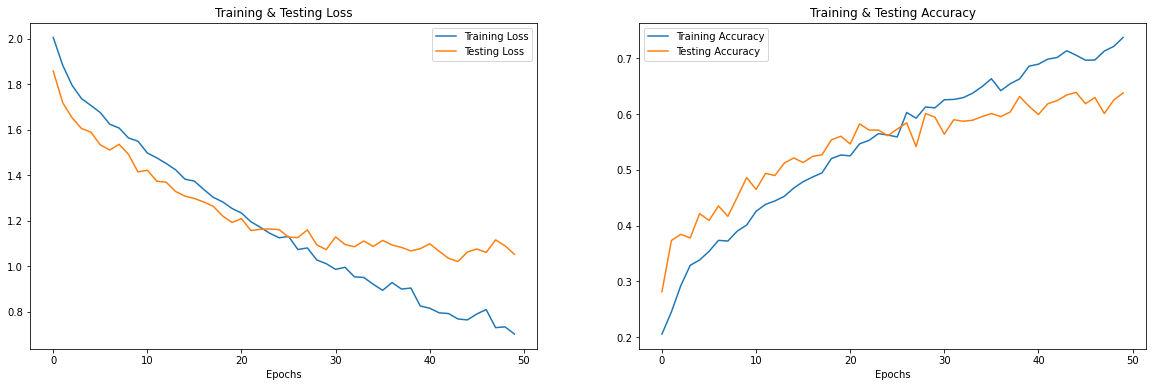

In [139]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [141]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [142]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,angry,angry
2,fear,fear
3,calm,calm
4,angry,angry
5,surprise,surprise
6,surprise,fear
7,happy,happy
8,fear,fear
9,happy,sad


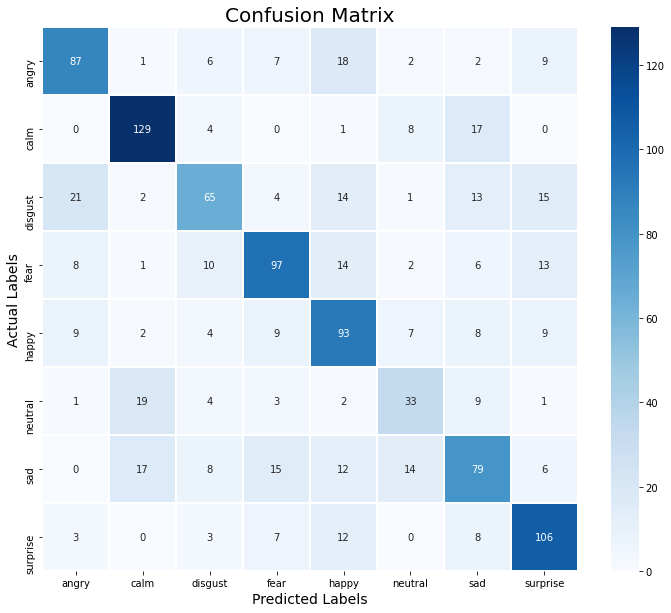

In [143]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.67      0.66      0.67       132
        calm       0.75      0.81      0.78       159
     disgust       0.62      0.48      0.54       135
        fear       0.68      0.64      0.66       151
       happy       0.56      0.66      0.61       141
     neutral       0.49      0.46      0.47        72
         sad       0.56      0.52      0.54       151
    surprise       0.67      0.76      0.71       139

    accuracy                           0.64      1080
   macro avg       0.63      0.62      0.62      1080
weighted avg       0.64      0.64      0.63      1080



In [145]:
y_pred

array([['fear'],
       ['angry'],
       ['fear'],
       ...,
       ['surprise'],
       ['calm'],
       ['sad']], dtype=object)

In [146]:
import visualkeras

In [147]:
from keras.models import load_model

model.save('emotions_mode.h5')